In [1]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import os
from scipy.spatial import distance
from scipy.stats import pearsonr
import random
import pandas as pd
import numpy as np
import pickle


os.chdir('../raw_data')


/lustre/BIF/nobackup/lmeli001/miniconda3/envs/cca/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/lustre/BIF/nobackup/lmeli001/miniconda3/envs/cca/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Functions to load and or write to pickle files

In [2]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [3]:
# load df with all info
path = './df_classes_max3_embeddings.pickle'
df_all = Files(path).load_pickle()#[:20000] #just a subset for scripting
df_all.shape

(41447, 8)

In [4]:
# # #drop inchikeys appering once, to make it possible to stratify based on inchikey
# df_all = df_all.groupby('cf_class').filter(lambda x : len(x)>=2)
# df_all.shape

In [5]:
#split into train and test dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.2, random_state=42)#, stratify=df_all['cf_class'])

#Split train dataset into train and validation set
train_df, val_df = train_test_split(df_all, test_size=0.2, random_state=42)


#extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
v1_train, v1_test = np.array([x for x in train_df['ms2ds']]), np.array([x for x in test_df['ms2ds']])
v2_train, v2_test = np.array([x for x in train_df['mol2vec']]), np.array([x for x in test_df['mol2vec']])

# validation
v1_val, v2_val = np.array([x for x in val_df['ms2ds']]), np.array([x for x in val_df['mol2vec']])

In [6]:
#creat CCA dataset 
train_dataset = CCA_Dataset([v1_train, v2_train])
test_dataset = CCA_Dataset([v1_test, v2_test])
val_dataset = CCA_Dataset([v1_val, v2_val])



batch_size = 700
train_loader , val_loader = get_dataloaders(train_dataset, \
                                            val_dataset,batch_size=batch_size,\
                                           num_workers=6,drop_last=False)
test_loader = get_dataloaders(test_dataset,\
                              batch_size=batch_size, \
                              num_workers=6,drop_last=False)

In [17]:
#code is still a mess: STRUCTURE!!!
#params
N = len(train_dataset)
latent_dims = 50
epochs = v2_train.shape[1]
lr = 0.001
#optimizer = optim.SGD(lr=0.01, momentum=0.9)



print('\n','-'*20,'\n Training CCA\n','-'*20)
cca = CCA(latent_dims=latent_dims).fit((v1_train, v2_train))# train cca as well for comparison

# define encoders
encoder_1 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v1_train.shape[1],\
                                  layer_sizes=(500,300,300)
                                )
                                     
encoder_2 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v2_train.shape[1], \
                                  layer_sizes=(500,300,300)
                                 )



 -------------------- 
 Training CCA
 --------------------


In [18]:
#extract cca correlation
cca_train_corr = cca.score([v1_train, v2_train])
cca_test_corr = cca.score([v1_val, v2_val])

In [19]:
# generate cca train projections
train_cca_z1, train_cca_z2 = cca.transform([v1_train, v2_train])
train_df['cca_z1'] = [x for x in train_cca_z1]
train_df['cca_z2'] = [x for x in train_cca_z2]

In [20]:
# # generate cca test projections
test_cca_z1, test_cca_z2 = cca.transform([v1_test, v2_test])
test_df['cca_z1'] = [x for x in test_cca_z1]
test_df['cca_z2'] = [x for x in test_cca_z2]

In [21]:
# generate cca val projections
val_cca_z1, val_cca_z2 = cca.transform([v1_val, v2_val])
val_df['cca_z1'] = [x for x in val_cca_z1]
val_df['cca_z2'] = [x for x in val_cca_z2]

In [27]:
%%time
#  # 1. DCCA
dcca = DCCA(
        latent_dims=latent_dims,
        encoders=[encoder_1, encoder_2],
        objective=objectives.CCA,
        optimizer='sgd',
        lr=lr)

 # Define the trainer
#dcca
dcca_trainer = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1)#,\
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="val/objective")])

#train
print('\n','-'*20,'\n Training DCCA\n','-'*20)
dcca_trainer.fit(dcca, train_loader,val_dataloaders=val_loader)



# # generate dcca train projections
# train_loader, val_loader  = get_dataloaders(train_dataset,val_dataset,\
#                                             batch_size=batch_size,drop_last=False)
                                            
train_z1, train_z2 = dcca.transform(train_loader)
train_df['dcca_z1'] = [x for x in train_z1]
train_df['dcca_z2'] = [x for x in train_z2]

# generate dcca test projections

test_z1, test_z2 = dcca.transform(test_loader)
test_df['dcca_z1'] = [x for x in test_z1]
test_df['dcca_z2'] = [x for x in test_z2]

# generate dcca val projections
#val_loader = get_dataloaders(batch_size=batch_size)
val_z1, val_z2 = dcca.transform(val_loader)
val_df['dcca_z1'] = [x for x in val_z1]
val_df['dcca_z2'] = [x for x in val_z2]

#score
dcca_train_corr = dcca.score(train_loader)
dcca_test_corr = dcca.score(test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 762 K 
----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)



 -------------------- 
 Training DCCA
 --------------------
Epoch 0:  98%|▉| 48/49 [00:01<00:00, 46.66it/s, loss=-22, v_num=4, train/objecti
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 49/49 [00:01<00:00, 36.20it/s, loss=-22, v_num=4, train/objecti
Epoch 1:  98%|▉| 48/49 [00:01<00:00, 47.20it/s, loss=-24, v_num=4, train/objecti
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 49/49 [00:01<00:00, 31.15it/s, loss=-24, v_num=4, train/objecti
Epoch 2:  98%|▉| 48/49 [00:00<00:00, 48.81it/s, loss=-25.5, v_num=4, train/objec
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 49/49 [00:01<00:00, 37.08it/s, loss=-25.5, v_num=4, train/objec
Epoch 3:  98%|▉| 48/49 [00:00<00:00, 50.91it/s, loss=-26.5, v_num=4, train/objec
Validation: 0it [00:00, ?it/s]
Valid

Epoch 43: 100%|█| 49/49 [00:01<00:00, 31.69it/s, loss=-38.9, v_num=4, train/obje
Epoch 44:  98%|▉| 48/49 [00:00<00:00, 48.16it/s, loss=-39.1, v_num=4, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 44: 100%|█| 49/49 [00:01<00:00, 36.62it/s, loss=-39.1, v_num=4, train/obje
Epoch 45:  98%|▉| 48/49 [00:00<00:00, 49.24it/s, loss=-39.2, v_num=4, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 45: 100%|█| 49/49 [00:01<00:00, 37.15it/s, loss=-39.2, v_num=4, train/obje
Epoch 46:  98%|▉| 48/49 [00:00<00:00, 49.00it/s, loss=-39.3, v_num=4, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 46: 100%|█| 49/49 [00:01<00:00, 32.33it/s, loss=-39.3, v_num=4, train/obje
Epoch 47:  98%|▉| 48/49 [00:00<00:00, 48.89it/s, loss=-39.5, v_num=4, train/obje
Validation: 0it 

Epoch 87: 100%|█| 49/49 [00:01<00:00, 38.74it/s, loss=-43, v_num=4, train/object
Epoch 88:  98%|▉| 48/49 [00:00<00:00, 51.87it/s, loss=-43.2, v_num=4, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 88: 100%|█| 49/49 [00:01<00:00, 31.32it/s, loss=-43.2, v_num=4, train/obje
Epoch 89:  98%|▉| 48/49 [00:00<00:00, 51.04it/s, loss=-43.2, v_num=4, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 89: 100%|█| 49/49 [00:01<00:00, 39.03it/s, loss=-43.2, v_num=4, train/obje
Epoch 90:  98%|▉| 48/49 [00:01<00:00, 46.83it/s, loss=-43.3, v_num=4, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 90: 100%|█| 49/49 [00:01<00:00, 36.98it/s, loss=-43.3, v_num=4, train/obje
Epoch 91:  98%|▉| 48/49 [00:01<00:00, 47.41it/s, loss=-43.4, v_num=4, train/obje
Validation: 0it 

Epoch 131: 100%|█| 49/49 [00:01<00:00, 33.14it/s, loss=-45.2, v_num=4, train/obj
Epoch 132:  98%|▉| 48/49 [00:00<00:00, 49.28it/s, loss=-45.3, v_num=4, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 132: 100%|█| 49/49 [00:01<00:00, 38.77it/s, loss=-45.3, v_num=4, train/obj
Epoch 133:  98%|▉| 48/49 [00:01<00:00, 47.19it/s, loss=-45.3, v_num=4, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 133: 100%|█| 49/49 [00:01<00:00, 31.95it/s, loss=-45.3, v_num=4, train/obj
Epoch 134:  98%|▉| 48/49 [00:01<00:00, 43.28it/s, loss=-45.3, v_num=4, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 134: 100%|█| 49/49 [00:01<00:00, 34.04it/s, loss=-45.3, v_num=4, train/obj
Epoch 135:  98%|▉| 48/49 [00:01<00:00, 46.73it/s, loss=-45.4, v_num=4, train/obj
Validation: 0it 

Epoch 175: 100%|█| 49/49 [00:01<00:00, 38.57it/s, loss=-46.6, v_num=4, train/obj
Epoch 176:  98%|▉| 48/49 [00:00<00:00, 51.74it/s, loss=-46.5, v_num=4, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 176: 100%|█| 49/49 [00:01<00:00, 34.38it/s, loss=-46.5, v_num=4, train/obj
Epoch 177:  98%|▉| 48/49 [00:01<00:00, 45.11it/s, loss=-46.3, v_num=4, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 177: 100%|█| 49/49 [00:01<00:00, 35.91it/s, loss=-46.3, v_num=4, train/obj
Epoch 178:  98%|▉| 48/49 [00:00<00:00, 49.49it/s, loss=-46.6, v_num=4, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 178: 100%|█| 49/49 [00:01<00:00, 34.10it/s, loss=-46.6, v_num=4, train/obj
Epoch 179:  98%|▉| 48/49 [00:01<00:00, 45.48it/s, loss=-46.7, v_num=4, train/obj
Validation: 0it 

Epoch 219: 100%|█| 49/49 [00:01<00:00, 37.45it/s, loss=-47.4, v_num=4, train/obj
Epoch 220:  98%|▉| 48/49 [00:00<00:00, 48.67it/s, loss=-47.5, v_num=4, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 220: 100%|█| 49/49 [00:01<00:00, 38.33it/s, loss=-47.5, v_num=4, train/obj
Epoch 221:  98%|▉| 48/49 [00:01<00:00, 46.65it/s, loss=-47.5, v_num=4, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 221: 100%|█| 49/49 [00:01<00:00, 32.03it/s, loss=-47.5, v_num=4, train/obj
Epoch 222:  98%|▉| 48/49 [00:00<00:00, 48.06it/s, loss=-47.3, v_num=4, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 222: 100%|█| 49/49 [00:01<00:00, 36.70it/s, loss=-47.3, v_num=4, train/obj
Epoch 223:  98%|▉| 48/49 [00:00<00:00, 51.04it/s, loss=-47.3, v_num=4, train/obj
Validation: 0it 

Epoch 263: 100%|█| 49/49 [00:01<00:00, 30.80it/s, loss=-47.9, v_num=4, train/obj
Epoch 264:  98%|▉| 48/49 [00:00<00:00, 50.25it/s, loss=-47.9, v_num=4, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 264: 100%|█| 49/49 [00:01<00:00, 38.60it/s, loss=-47.9, v_num=4, train/obj
Epoch 265:  98%|▉| 48/49 [00:01<00:00, 38.30it/s, loss=-47.9, v_num=4, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 265: 100%|█| 49/49 [00:01<00:00, 30.88it/s, loss=-47.9, v_num=4, train/obj
Epoch 266:  98%|▉| 48/49 [00:00<00:00, 51.27it/s, loss=-48, v_num=4, train/objec
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 266: 100%|█| 49/49 [00:01<00:00, 32.06it/s, loss=-48, v_num=4, train/objec
Epoch 267:  98%|▉| 48/49 [00:00<00:00, 53.50it/s, loss=-47.9, v_num=4, train/obj
Validation: 0it 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|█| 49/49 [00:01<00:00, 39.22it/s, loss=-48.2, v_num=4, train/obj
CPU times: user 2h 26min 48s, sys: 3min 34s, total: 2h 30min 23s
Wall time: 7min 10s
Epoch 180:  98%|▉| 48/49 [31:13<00:39, 39.02s/it, loss=-45.8, v_num=2, train/obj
Epoch 0:   0%|                                           | 0/49 [30:33<?, ?it/s]
Epoch 180:  98%|▉| 48/49 [31:25<00:39, 39.29s/it, loss=-45.8, v_num=2, train/obj
Epoch 0:   0%|                                           | 0/49 [30:46<?, ?it/s]
Epoch 180:  98%|▉| 48/49 [31:29<00:39, 39.37s/it, loss=-45.8, v_num=2, train/obj
Epoch 180:  98%|▉| 48/49 [31:29<00:39, 39.37s/it, loss=-45.8, v_num=2, train/obj
Epoch 180:  98%|▉| 48/49 [31:29<00:39, 39.37s/it, loss=-45.8, v_num=2, train/obj
Epoch 0:   0%|                                           | 0/49 [30:50<?, ?it/s]
Epoch 180:  98%|▉| 48/49 [31:43<00:39, 39.66s/it, loss=-45.8, v_num=2, train/obj
Epoch 0:   0%|                                           | 0/49 [31:04<?, ?it/s]
Epoch 180:  98%|▉| 48/49

In [30]:
%%time
# 2. SDL
sdl = DCCA_SDL(latent_dims,optimizer='sgd',
                N=N, encoders=[encoder_1, encoder_2],
                lam=0.0001, lr=lr,
                objective=objectives.CCA) # train size

#train
trainer_sdl = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1)#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

print('\n','-'*20,'\n Training SDL\n','-'*20)
trainer_sdl.fit(sdl, train_loader,val_loader)



train_z1, train_z2 = sdl.transform(train_loader)
train_df['sdl_z1'] = [x for x in train_z1]
train_df['sdl_z2'] = [x for x in train_z2]

# generate dcca test projections
#test_loader = get_dataloaders(test_dataset)#,batch_size=batch_size,drop_last=False)#,batch_size=batch_size)
test_z1, test_z2 = sdl.transform(test_loader)
test_df['sdl_z1'] = [x for x in test_z1]
test_df['sdl_z2'] = [x for x in test_z2]

# generate dcca val projections
#val_loader = get_dataloaders(batch_size=batch_size)
val_z1, val_z2 = sdl.transform(val_loader)
val_df['sdl_z1'] = [x for x in val_z1]
val_df['sdl_z2'] = [x for x in val_z2]

#score
sdl_train_corr = sdl.score(train_loader)
sdl_test_corr = sdl.score(test_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 762 K 
1 | mse      | MSELoss    | 0     
2 | bns      | ModuleList | 0     
----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)



 -------------------- 
 Training SDL
 --------------------
Epoch 0:  98%|▉| 48/49 [00:00<00:00, 51.71it/s, loss=1.8, v_num=5, train/objecti
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 49/49 [00:01<00:00, 39.00it/s, loss=1.8, v_num=5, train/objecti
Epoch 1:  98%|▉| 48/49 [00:00<00:00, 52.73it/s, loss=1.53, v_num=5, train/object
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 49/49 [00:01<00:00, 34.35it/s, loss=1.53, v_num=5, train/object
Epoch 2:  98%|▉| 48/49 [00:00<00:00, 50.08it/s, loss=1.41, v_num=5, train/object
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 49/49 [00:01<00:00, 38.17it/s, loss=1.41, v_num=5, train/object
Epoch 3:  98%|▉| 48/49 [00:00<00:00, 51.58it/s, loss=1.33, v_num=5, train/object
Validation: 0it [00:00, ?it/s]
Valida

Epoch 43: 100%|█| 49/49 [00:01<00:00, 41.02it/s, loss=0.948, v_num=5, train/obje
Epoch 44:  98%|▉| 48/49 [00:00<00:00, 52.03it/s, loss=0.947, v_num=5, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 44: 100%|█| 49/49 [00:01<00:00, 34.61it/s, loss=0.947, v_num=5, train/obje
Epoch 45:  98%|▉| 48/49 [00:00<00:00, 53.25it/s, loss=0.945, v_num=5, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 45: 100%|█| 49/49 [00:01<00:00, 40.43it/s, loss=0.945, v_num=5, train/obje
Epoch 46:  98%|▉| 48/49 [00:00<00:00, 51.90it/s, loss=0.943, v_num=5, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 46: 100%|█| 49/49 [00:01<00:00, 34.45it/s, loss=0.943, v_num=5, train/obje
Epoch 47:  98%|▉| 48/49 [00:00<00:00, 54.50it/s, loss=0.941, v_num=5, train/obje
Validation: 0it 

Epoch 87: 100%|█| 49/49 [00:01<00:00, 38.87it/s, loss=0.886, v_num=5, train/obje
Epoch 88:  98%|▉| 48/49 [00:00<00:00, 52.39it/s, loss=0.885, v_num=5, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 88: 100%|█| 49/49 [00:01<00:00, 39.76it/s, loss=0.885, v_num=5, train/obje
Epoch 89:  98%|▉| 48/49 [00:00<00:00, 50.18it/s, loss=0.883, v_num=5, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 89: 100%|█| 49/49 [00:01<00:00, 33.57it/s, loss=0.883, v_num=5, train/obje
Epoch 90:  98%|▉| 48/49 [00:00<00:00, 53.72it/s, loss=0.883, v_num=5, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 90: 100%|█| 49/49 [00:01<00:00, 40.58it/s, loss=0.883, v_num=5, train/obje
Epoch 91:  98%|▉| 48/49 [00:00<00:00, 49.89it/s, loss=0.881, v_num=5, train/obje
Validation: 0it 

Epoch 131: 100%|█| 49/49 [00:01<00:00, 34.89it/s, loss=0.852, v_num=5, train/obj
Epoch 132:  98%|▉| 48/49 [00:01<00:00, 46.93it/s, loss=0.85, v_num=5, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 132: 100%|█| 49/49 [00:01<00:00, 36.38it/s, loss=0.85, v_num=5, train/obje
Epoch 133:  98%|▉| 48/49 [00:00<00:00, 48.70it/s, loss=0.851, v_num=5, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 133: 100%|█| 49/49 [00:01<00:00, 37.38it/s, loss=0.851, v_num=5, train/obj
Epoch 134:  98%|▉| 48/49 [00:00<00:00, 51.91it/s, loss=0.85, v_num=5, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 134: 100%|█| 49/49 [00:01<00:00, 34.30it/s, loss=0.85, v_num=5, train/obje
Epoch 135:  98%|▉| 48/49 [00:00<00:00, 49.68it/s, loss=0.849, v_num=5, train/obj
Validation: 0it 

Epoch 175: 100%|█| 49/49 [00:01<00:00, 39.44it/s, loss=0.826, v_num=5, train/obj
Epoch 176:  98%|▉| 48/49 [00:00<00:00, 51.45it/s, loss=0.826, v_num=5, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 176: 100%|█| 49/49 [00:01<00:00, 34.30it/s, loss=0.826, v_num=5, train/obj
Epoch 177:  98%|▉| 48/49 [00:00<00:00, 52.29it/s, loss=0.826, v_num=5, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 177: 100%|█| 49/49 [00:01<00:00, 39.87it/s, loss=0.826, v_num=5, train/obj
Epoch 178:  98%|▉| 48/49 [00:00<00:00, 54.78it/s, loss=0.826, v_num=5, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 178: 100%|█| 49/49 [00:01<00:00, 40.99it/s, loss=0.826, v_num=5, train/obj
Epoch 179:  98%|▉| 48/49 [00:00<00:00, 50.85it/s, loss=0.825, v_num=5, train/obj
Validation: 0it 

Epoch 219: 100%|█| 49/49 [00:01<00:00, 29.94it/s, loss=0.807, v_num=5, train/obj
Epoch 220:  98%|▉| 48/49 [00:00<00:00, 51.84it/s, loss=0.807, v_num=5, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 220: 100%|█| 49/49 [00:01<00:00, 39.55it/s, loss=0.807, v_num=5, train/obj
Epoch 221:  98%|▉| 48/49 [00:00<00:00, 50.43it/s, loss=0.807, v_num=5, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 221: 100%|█| 49/49 [00:01<00:00, 33.54it/s, loss=0.807, v_num=5, train/obj
Epoch 222:  98%|▉| 48/49 [00:00<00:00, 53.80it/s, loss=0.805, v_num=5, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 222: 100%|█| 49/49 [00:01<00:00, 40.88it/s, loss=0.805, v_num=5, train/obj
Epoch 223:  98%|▉| 48/49 [00:00<00:00, 53.39it/s, loss=0.806, v_num=5, train/obj
Validation: 0it 

Epoch 263: 100%|█| 49/49 [00:01<00:00, 37.30it/s, loss=0.791, v_num=5, train/obj
Epoch 264:  98%|▉| 48/49 [00:01<00:00, 38.64it/s, loss=0.79, v_num=5, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 264: 100%|█| 49/49 [00:01<00:00, 27.86it/s, loss=0.79, v_num=5, train/obje
Epoch 265:  98%|▉| 48/49 [00:01<00:00, 46.12it/s, loss=0.789, v_num=5, train/obj
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 265: 100%|█| 49/49 [00:01<00:00, 36.13it/s, loss=0.789, v_num=5, train/obj
Epoch 266:  98%|▉| 48/49 [00:00<00:00, 51.58it/s, loss=0.79, v_num=5, train/obje
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 266: 100%|█| 49/49 [00:01<00:00, 34.07it/s, loss=0.79, v_num=5, train/obje
Epoch 267:  98%|▉| 48/49 [00:01<00:00, 44.50it/s, loss=0.789, v_num=5, train/obj
Validation: 0it 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|█| 49/49 [00:01<00:00, 32.23it/s, loss=0.777, v_num=5, train/obj
CPU times: user 2h 16min 28s, sys: 4min 16s, total: 2h 20min 44s
Wall time: 6min 55s


In [24]:
# sdl_train_corr = sdl.score(train_loader)
# sdl_test_corr = sdl.score(test_loader)

In [31]:
# To construct image name
embedding = 'MS2DeepScore'
method = 'ALL_3_hidden'
data = 'max3'
dims = latent_dims

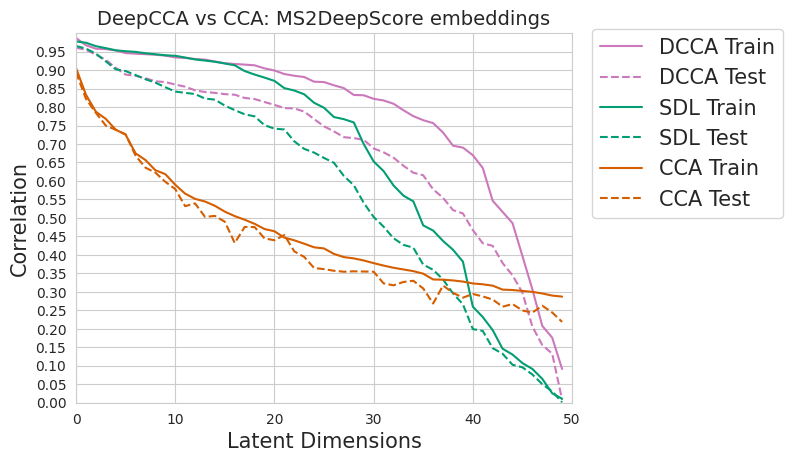

In [32]:
# plot train correlation vs test correlation
x=[x for x in range(latent_dims)]
fig, ax = plt.subplots()

sns.set_style('whitegrid')

line = ['solid', 'dashed']

#justice for the color blind :)
palette = [sns.color_palette("colorblind")[4],\
           sns.color_palette("colorblind")[2],\
           sns.color_palette("colorblind")[3]] 

dfs = [[dcca_train_corr, dcca_test_corr],\
       [sdl_train_corr, sdl_test_corr],\
       [cca_train_corr,cca_test_corr]]

for i, df in enumerate(dfs):
    #train
    sns.lineplot(x=x,y=df[0], \
                 color = palette[i],
                 linestyle=line[0],ax=ax)
    #test
    sns.lineplot(x=x,y=df[1],\
                 color = palette[i],
                 linestyle=line[1], ax=ax)

    plt.legend(labels=['DCCA Train', 'DCCA Test',\
                      'SDL Train', 'SDL Test',\
                      'CCA Train', 'CCA Test'], \
                       loc=(1.04, 0.5),\
                    fontsize=15)#title='Algorithm', 
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.ylim(0, 1.0)
plt.title(label=f'DeepCCA vs CCA: {embedding} embeddings',\
          fontsize=14,loc='center')
plt.xlim(0, latent_dims)

plt.yticks(np.arange(0, 1, step=0.05))
plt.savefig(f'../plots/{method}_{data}_{dims}_vs_cca_{embedding}.png',\
           transparent=False,bbox_inches = 'tight')
plt.show()

#there is problem: sdl and dcca certanly will not be that close

In [33]:
#write dfs (with the z score from dcca,cca and sdl) to file

dfs = [train_df,test_df,val_df]

paths = ['./max3_train_df_with_z.pickle',
        './max3_test_df_with_z.pickle',
        './max3_val_df_with_z.pickle']

for df, path in zip(dfs,paths):
    Files(path).write_to_file(df)
    

Epoch 180:  98%|▉| 48/49 [38:41<00:48, 48.36s/it, loss=-45.8, v_num=2, train/obj
Epoch 0:   0%|                                           | 0/49 [38:02<?, ?it/s]


### Assess Prediction Performance: DCCA

##### Predict Structure from spectra Embeddings

1. Calculate:(using euc only for now since its faster)

    1. Euclidean Distance
    2. Cosine Distance
    3. Correlation

2. Calculate Tanimoto score of top scoring hits based on the above metric

3. Sample a few structures to draw

In [47]:
def predict(subject_df,query_df,\
            method,dims,metric='euc'): #both dfs should have z1 and z2 coloumns

    preds = {}
    
    for query_index, query in enumerate(query_df[f'{method}_z1']): #(query z1)
        
        #calculate tanimotos if it does not meet threshold;pass
        
        #query = query_df.loc[query_index,'z1']
        preds[query_index] = []
        for subject in subject_df[f'{method}_z2']:#(subject z2)
        
            #subject = subject_df.loc[subject_index,'z2']
            if metric == 'corr':
                corr = pearsonr(query[:dims], subject[:dims])[0]
                preds[query_index].append(corr)
        
            if metric== 'euc':
                euc = distance.euclidean(query[:dims], subject[:dims])
                preds[query_index].append(euc)
        
            if metric == 'cos':
                cos = distance.cosine(query[:dims], subject[:dims])
                preds[query_index].append(cos)
    
    return preds
    

In [48]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm

In [49]:
# function to calculate pairwise tanimoto scores
def tanimoto(smi1, smi2):
    #molecule
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    #fingerprint
    fp1 = Chem.RDKFingerprint(mol1)
    fp2 = Chem.RDKFingerprint(mol2)
    
    #similarity
    score = round(DataStructs.FingerprintSimilarity(fp1,fp2),4)
    return score

In [50]:
# function to calculate tanimoto scores for n hits returns a max tanimotos and {query:top_hit}
def get_tanimotos(preditions_dict,\
                  subject_df,query_df, metric,nn=100):
    tanimotos = []
    pred = {} #key is the query index, value is the top hit index
    
    for query_index, values in preditions_dict.items(): # values == score(corr, euc or cosine)
        pred[query_index] = []
        
        #select top n hits for each query based on correlation
        if metric == 'corr':
            top_hits = np.sort(values)[::-1][:nn] # higher corr the better
            
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            subject_hit_indices = []
            for hit in top_hits:
                
                subject_index = values.index(hit)
                subject_hit_indices.append(subject_index) #to trace the index of the hits
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                top_hits_scores.append(tanimoto(smile1,smile2))
                #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            
            pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)],max(top_hits_scores)]) #appends the index of the hit with highest tanimoto
            
        #select closest n hits for each query based on cosine/euclidian distance
        else: #may be elif metric != 'corr'
            top_hits = np.sort(values)[:nn] #if its euc or cos; the lower the better
    
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            subject_hit_indices = []
            for hit in top_hits:
                
                
                
                subject_index = values.index(hit)
                subject_hit_indices.append(subject_index) #to trace the index of the hits
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                top_hits_scores.append(tanimoto(smile1,smile2))
            #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)],max(top_hits_scores)])#appends the index of the hit with highest tanimoto
    return tanimotos, pred
    

In [51]:
def random_tanimoto(preditions_dict,
                subject_df,query_df):
    tanimotos = []
    
    for query_index, values in preditions_dict.items():
        subject_index = random.randint(0,len(values)) #randomly pick subject index as hits
        
        smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
        smile2 = query_df['smiles'].iloc[query_index]#extract the query smile 
        
        tanimotos.append(tanimoto(smile1,smile2))
    return tanimotos
        
        

In [ ]:
%%time

dims = 25
#n=50
#nn=100
metric = 'euc'
#predict sdl euc
test_sdl_euc = predict(subject_df=train_df,\
                        query_df=test_df,dims=dims,\
                        method='sdl', metric=metric)
#tanimotos, and the top hit    
test_sdl_euc_tanimotos, hits_sdl = get_tanimotos(test_sdl_euc, \
                                       subject_df=train_df,\
                                        query_df=test_df,\
                                        metric=metric)
# dcca
test_dcca_euc = predict(subject_df=train_df,\
                        query_df=test_df,dims=dims,\
                        method='dcca', metric=metric)
#tanimotos, and the top hit    
test_dcca_euc_tanimotos, hits_dcca = get_tanimotos(test_dcca_euc, \
                                       subject_df=train_df,\
                                        query_df=test_df,\
                                        metric=metric)

#cca
test_cca_euc = predict(subject_df=train_df,\
                       query_df=test_df,dims=dims,\
                       method='cca',metric=metric)
#tanimotos, and the top hit 
test_cca_euc_tanimotos,hits_cca = get_tanimotos(test_cca_euc, \
                       subject_df=train_df,\
                       query_df=test_df, \
                                       metric=metric)

#random tanimotos
random_tanimotos = random_tanimoto(test_cca_euc, \
                                       subject_df=train_df,\
                                       query_df=test_df)



In [ ]:
eucs = [test_sdl_euc,test_dcca_euc,test_cca_euc]
hits = [hits_sdl,hits_dcca,hits_cca]
tanis = [test_sdl_euc_tanimotos,test_dcca_euc_tanimotos,test_cca_euc_tanimotos]




In [ ]:
paths = ['./max3_sdl_euc.pickle', './max3_dcca_euc.pickle','./max3_cca_euc.pickle']

for euc, path in zip(eucs,paths):
    Files(path).write_to_file(euc)

In [ ]:
paths = ['./max3_sdl_hits.pickle', './max3_dcca_hits.pickle','./max3_cca_hits.pickle']

for hit, path in zip(hits,paths):
    Files(path).write_to_file(hit)

In [ ]:
paths = ['./max3_sdl_tanimoto.pickle', './max3_dcca_tanimoto.pickle','./max3_cca_tanimoto.pickle']

for tan, path in zip(tanis,paths):
    Files(path).write_to_file(tan)

In [ ]:
#plot the distribution of the three top tanimotos from the three metrics
dist_list = [test_cca_euc_tanimotos,
             test_sdl_euc_tanimotos,
             test_dcca_euc_tanimotos,
            random_tanimotos]
for dist in dist_list:
    ax=sns.kdeplot(x=dist,shade=True)
plt.legend(labels=['CCA',
                   'SDL',
                   'DCCA',
                   'Random'
                  ], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution', fontsize=15)
plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
           transparent=False,bbox_inches = 'tight')
plt.show()

#### Draw Random predicted molecule

In [4]:
#os.listdir()

In [5]:
# load hits
paths = ['./max3_sdl_hits.pickle','./max3_dcca_hits.pickle','./max3_cca_hits.pickle']
hits_sdl = Files(paths[0]).load_pickle()
hits_dcca = Files(paths[1]).load_pickle()
hits_cca = Files(paths[2]).load_pickle()

In [9]:
#load dfs
paths = ['./max3_train_df_with_z.pickle',
        './max3_test_df_with_z.pickle',
        './max3_val_df_with_z.pickle']

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()
val_df = Files(paths[2]).load_pickle()


In [7]:
from rdkit import Chem
from rdkit.Chem import Draw

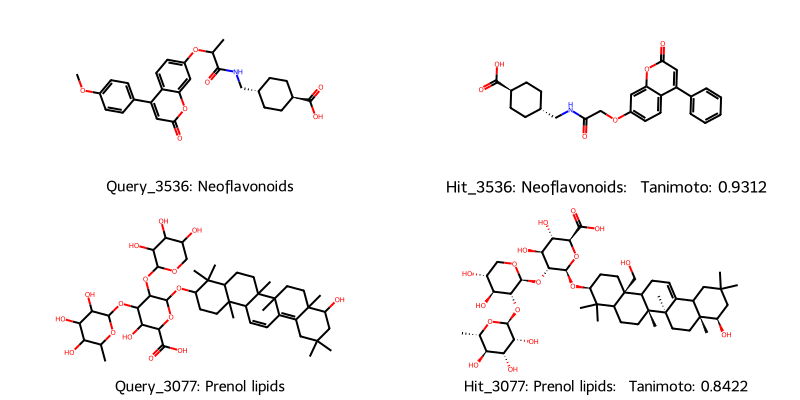

In [80]:
#randomly pick a query
keys = random.choices(list(hits_sdl.keys()),k=2)
subset_hits = {key: hits_sdl[key] for key in keys}

mols = []

classes = []
for query_index, subject_index in subset_hits.items():
    
    
    query_smile = test_df['smiles'].iloc[query_index]
    query_class = test_df['cf_class'].iloc[query_index]
    
    if type(query_class) == float:
        query_class = 'NAN'
        #classes = [f'Query:\t{query_class}',]
    
    classes.append(f'Query_{query_index}: {query_class}')#else
    
    query = Chem.MolFromSmiles(query_smile)
    
    subject_smile = train_df['smiles'].iloc[subject_index[0][0]]
    subject = Chem.MolFromSmiles(subject_smile)
    cl = train_df['cf_class'].iloc[subject_index[0][0]]
    if type(cl) == float:
        cl = 'NAN'
    subject_class = f'\tHit_{query_index}: {cl}:\tTanimoto: {subject_index[0][1]}'
    #print(query_class,subject_class)
    classes.append(subject_class)
    mols.append(query)
    mols.append(subject) #to expand later to include top 5 hits
    #break
Draw.MolsToGridImage(mols,
                    molsPerRow=2, 
                    legends = classes,
                    subImgSize=(400,200),
                            returnPNG=True)


#### Never mind the codes below; you have reached the end of important codes

In [310]:
#random drawing for top 5 hits

# #randomly pick a query
# keys = random.sample(test_cca_corr_tanimotos.keys(),5)
# sample_dict = {key: test_cca_corr_tanimotos[key] for key in keys}

# #draw select top 5 hits
# all_mols = []
# #scores = []
# mol_classes = []
# #os.chdir('../compounds')
# for query_index, values in tqdm(sample_dict.items()):
#     top_hits = np.sort(values)[:5]
#     tanimotos = []
    
#     #draw the query
    
#     query_smile= val_df['smiles'].iloc[query_index]
#     query_class = val_df['cf_class'].iloc[query_index]
#     if type(query_class) == float:
#         query_class = 'NAN'
#         classes = [f'Query:\t{query_class}',]
#     classes = [f'QUERY:\t{query_class}',]
#     query = Chem.MolFromSmiles(query_smile)
#     #Draw.MolToFile(query, f"dcca_max_corr_query_{query_index}_{query_class}.png")
#     #Draw.MolsToGridImage(query)
#     #draw top 5 hits
#     subjects = [query,]
#     for hit_index, hit in enumerate(top_hits):
#         subject_index = values.index(hit)
#         subject_smile = train_df['smiles'].iloc[subject_index]
        
        
#         subject = Chem.MolFromSmiles(subject_smile)
#         subjects.append(subject)
#         #Draw.MolToFile(subject, f"dcca_max_corr_query_{query_index}_hit_{hit_index}_{subject_class}.png")
#         cl = train_df['cf_class'].iloc[subject_index]
#         if type(cl) == float:
#             cl = 'NAN'
#             subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
#             classes.append(subject_class)
#         else:
#             subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
#             classes.append(subject_class)
#         #check tanimotos for the random selections
#         tanimotos.append(tanimoto(query_smile,subject_smile))
#    # scores.append([(query_index,query_class),tanimotos])
#     all_mols.append(subjects)
#     mol_classes.append(classes)


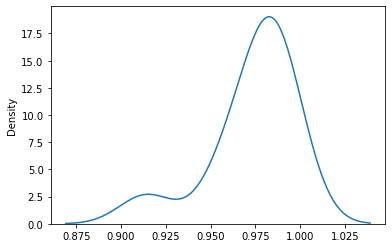

In [312]:
#just to see the highest corr attained
corr = []
for query_index, values in test_sdl_corr.items():
    corr.append(max(values))
    
ax=sns.kdeplot(x=corr,shade=False)

In [ ]:
for key, values in sample_dict.items():
    print(key,max(values))
    print(np.sort(values)[::-1][0:5])